# Model 1 extension and modification

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns
import os
import duckdb

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [3]:
cleaned_parquet = "../data/cleaned_data/cleaned_fraud.parquet"

print(f"📊 Original size: {os.path.getsize(cleaned_parquet) / (1024**3):.2f} GB")

con = duckdb.connect()

📊 Original size: 0.14 GB


In [4]:
# Load full dataset
df = con.execute(f"SELECT * FROM '{cleaned_parquet}'").fetch_df()

# 1. EDA & Pattern Detection
print("Original Class Distribution:")
print(df['is_fraud'].value_counts(normalize=True))

# Check for negative time values (Pattern Detection)
neg_time = df[df['time_since_last_transaction'] < 0]
print(f"\nRows with negative time_since_last_transaction: {len(neg_time)}")
if len(neg_time) > 0:
    print("Negative values might indicate data errors or specific flags. Treating as valid numeric for now.")

Original Class Distribution:
is_fraud
False    0.956244
True     0.043756
Name: proportion, dtype: float64

Rows with negative time_since_last_transaction: 2051331
Negative values might indicate data errors or specific flags. Treating as valid numeric for now.


In [5]:
con.close()

In [6]:


# 2. Data Preparation for SMOTE
# - Drop high cardinality identifiers
# - Encode categorical variables
# - Scale numerical variables

categorical_cols = ['transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel']
numerical_cols = ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score', 'hour', 'day_of_week']
drop_cols = ['sender_account', 'receiver_account', 'ip_address', 'device_hash', 'year', 'month', 'day_of_month'] # high-cardinality identifiers that do not generalize well and can negatively affect the model training. Dropping date because we already extracted more meaningful features like hours and days of the week

# Separate Features and Target
X = df.drop(columns=['is_fraud'] + drop_cols, errors='ignore')
y = df['is_fraud']

# Split Data (Best Practice: Split BEFORE SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratifying by y to ensure both splits have an equal amount of the target variable y

# Preprocessing Pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])




In [ ]:
# Next Steps
# After Smote, we can train and evaluate multiple models on the training and test (no-smote) data

In [ ]:
# 4. Full Pipeline: Preprocess → SMOTE → Model - automatic preprocessing applying SMOTE in CV
smote_pipeline = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", LogisticRegression(max_iter=1000, n_jobs=-1)) # logistic regression uses iterative optimization to find the best coefficients, if max_iter is too low, the model may not fully converge, resulting in suboptimal predictions. n_jobs (-1), means use all available CPU cores for parallel processing
])


In [8]:
# Run CROSS VALIDATION - this is training and evaluation loop
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    smote_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

print(scores.mean(), scores.std())

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/miniconda3/

0.08051265893907165 0.0004138523697297887


### Cross-validation → choose best model → final training → test evaluation
- CV only evaluates the pipeline configuration.
- `.fit()` trains the final model using that configuration.

In [12]:
# Train final model
smote_pipeline.fit(X_train, y_train) # train on the full training set


# Evaluate
y_pred = smote_pipeline.predict(X_test)
y_proba = smote_pipeline.predict_proba(X_test)[:, 1]  # fraud probability
y_pred

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


array([ True,  True,  True, ...,  True, False, False])

## Model Evaluation Report & Metrics
 

In [ ]:
from sklearn.metrics import classification_report
# Classification report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

       False       0.96      0.49      0.65    784787
        True       0.04      0.51      0.08     35911

    accuracy                           0.49    820698
   macro avg       0.50      0.50      0.37    820698
weighted avg       0.92      0.49      0.63    820698



Precision (Fraud = 0.04) → When the model predicts fraud, it's correct only 4% of the time.  
→ Very high false positive rate.
• Recall (Fraud = 0.51) → The model catches 51% of actual fraud cases.  
→ Decent sensitivity, but not great.
• F1-score (Fraud = 0.08) → The balance between precision and recall is poor.  
→ Model is struggling to make useful fraud predictions.
• Accuracy = 0.49 → Misleading due to class imbalance.  
→ Accuracy is not meaningful here.

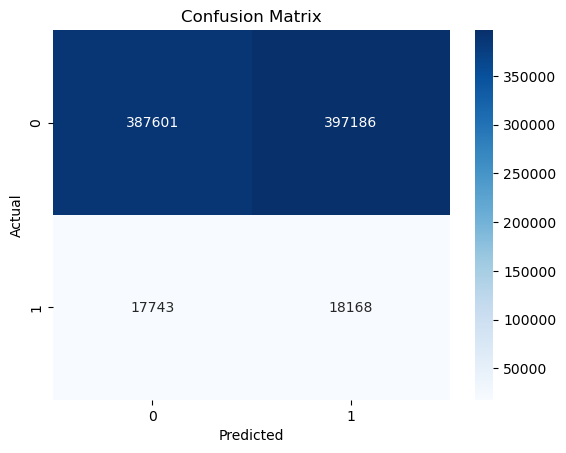

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# True Negatives
# False Positives
# False Negatives
# True Positives

# Interpretation
keys:
0 = non-fraud
1 = fraud

- True Negatives (387,601) → Correctly predicted non-fraud
• False Positives (397,186) → Predicted fraud when it wasn’t
• False Negatives (17,743) → Missed fraud cases
• True Positives (18,168) → Correctly predicted fraud

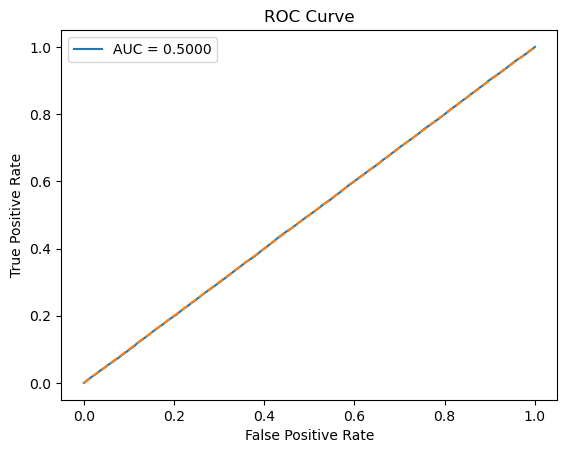

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve + ROC-AUC

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Interpretation:
• The model has no discriminative power
• It cannot distinguish between fraud and non‑fraud
• It’s performing exactly like flipping a coin

Why this happens:
• The predicted probabilities (y_proba) are not informative
• The model is likely overfitting to synthetic SMOTE samples or underfitting due to poor signal
• Logistic Regression may be too weak for this dataset

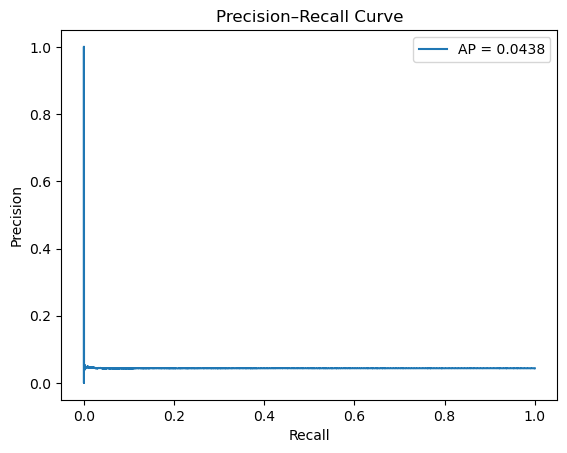

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision–Recall Curve + PR-AUC (critical for fraud)

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

Interpretation:
• When the model predicts fraud, it’s almost always wrong
• Precision is near zero across most recall levels
• The model is not useful for identifying fraud cases

Why this matters:
• Fraud detection is all about precision and recall
• A low AP means our model would waste resources chasing false alarms
• Even though recall is ~0.5, the precision is so low that it’s not actionable

In [ ]:
from sklearn.metrics import f1_score

# F1 Score (macro, micro, weighted)
print("F1 (binary):", f1_score(y_test, y_pred))
print("F1 (macro):", f1_score(y_test, y_pred, average="macro"))
print("F1 (weighted):", f1_score(y_test, y_pred, average="weighted"))

F1 (binary): 0.08052031511417904
F1 (macro): 0.3659394315193676
F1 (weighted): 0.6263805757856531


Interpretation:
• F1 barely improves at lower thresholds, meaning the model is just guessing fraud more often but not more accurately.
• After 0.50, the model stops predicting fraud entirely — precision goes up, but recall drops to zero, so F1 collapses.
• Macro F1 = 0.36 and binary F1 = 0.08 → the model is heavily biased toward the majority class (non-fraud).

In [17]:
import numpy as np
# Threshold tuning - finding the best operating point for the business case
thresholds = np.arange(0.1, 0.9, 0.05)

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    print(f"Threshold {t:.2f} → F1 = {f1:.4f}")

Threshold 0.10 → F1 = 0.0838
Threshold 0.15 → F1 = 0.0838
Threshold 0.20 → F1 = 0.0838
Threshold 0.25 → F1 = 0.0838
Threshold 0.30 → F1 = 0.0838
Threshold 0.35 → F1 = 0.0838
Threshold 0.40 → F1 = 0.0838
Threshold 0.45 → F1 = 0.0838
Threshold 0.50 → F1 = 0.0805
Threshold 0.55 → F1 = 0.0000
Threshold 0.60 → F1 = 0.0000
Threshold 0.65 → F1 = 0.0000
Threshold 0.70 → F1 = 0.0000
Threshold 0.75 → F1 = 0.0000
Threshold 0.80 → F1 = 0.0000
Threshold 0.85 → F1 = 0.0000


At this point, it would be interesting to see what the results would be using a 50-50 approach of the dataset instead of SMOTE

Challenges:
SMOTE may create unrealistic synthetic samples if minority class is extremely sparse

Recommended Optimizations
Subsampling Strategy: Train on a stratified sample (e.g., 500K-1M rows) to speed up experimentation, then validate on full dataset

Incremental Learning: Consider partial_fit or online learning approaches

Alternative Sampling: Use SMOTEENN (SMOTE + Edited Nearest Neighbors) to clean synthetic samples

Reduce Trees: Start with n_estimators=100 for prototyping, scale up if needed

Feature Selection: Reduce dimensionality before SMOTE to speed up neighbor calculations

Distributed Computing: Consider Spark MLlib or Dask for true scalability with 6M+ rows

# Using Other ML models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

rf_pipeline = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        n_jobs=-1,
        random_state=42
    ))
])

In [ ]:
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

xgb_pipeline = ImbPipeline([
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        early_stopping_rounds=20
    ))
])

In [ ]:

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in {
    "RandomForest": rf_pipeline,
    "XGBoost": xgb_pipeline
}.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    print(f"{name}: mean F1={scores.mean():.4f}, std={scores.std():.4f}")

In [ ]:
# After which we can then train the models
xgb_pipeline.fit(X_train, y_train)
# OR 
# rf_pipeline.fit(X_train, y_train)

In [ ]:
rf_pipeline.fit(X_train, y_train)


#  feature importance across Logistic Regression, RandomForest, and XGBoost

In [ ]:
def get_feature_names(preprocessor):
    num_features = preprocessor.named_transformers_['num'].get_feature_names_out()
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
    return list(num_features) + list(cat_features)

In [ ]:
feature_names = get_feature_names(smote_pipeline.named_steps["preprocess"])
feature_names = get_feature_names(rf_pipeline.named_steps["preprocess"])
feature_names = get_feature_names(xgb_pipeline.named_steps["preprocess"])

In [ ]:
import pandas as pd
import numpy as np

logreg = smote_pipeline.named_steps["model"]

logreg_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": np.abs(logreg.coef_[0])
}).sort_values("importance", ascending=False)

# (LogReg uses coefficients)
# • Large positive coefficient → increases fraud probability
# • Large negative coefficient → decreases fraud probability
# • Logistic Regression captures linear relationships only

In [ ]:
# (RandomForest uses Gini importance)
# • Measures how much each feature reduces impurity
# • Captures nonlinear interactions
# • Tends to favor high‑cardinality one‑hot encoded features

rf_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": smote_pipeline.named_steps["model"].feature_importances_
}).sort_values("importance", ascending=False)

In [ ]:
# XGBoost uses gain, the most meaningful metric
# Gain = how much a feature improves splits
# • XGBoost captures complex nonlinear patterns
# • Often the most reliable importance measure for fraud

xgb_model = smote_pipeline.named_steps["model"]

xgb_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.get_booster().get_score(importance_type="gain")
}).sort_values("importance", ascending=False)


In [ ]:
# Combine all three into a comparison table

comparison = (
    logreg_importance.rename(columns={"importance": "logreg"})
    .merge(rf_importance.rename(columns={"importance": "rf"}), on="feature", how="outer")
    .merge(xgb_importance.rename(columns={"importance": "xgb"}), on="feature", how="outer")
    .fillna(0)
)

comparison.sort_values("xgb", ascending=False).head(20)

Consider:
Hyperparameter tuning on max_depth, min_samples_split, etc.
Ensemble methods - Combining different model types (XGBoost, LightGBM) often beats deeper Random Forests

